In [1]:
import importlib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import itertools
import joblib
from matplotlib import pyplot as plot
import os
import gc
from load_dataset import get_dataloader
import utils

In [2]:
class ConvNet1D(nn.Module):
    def __init__(self, input_size, output_size, in_channels,
                 conv_k = 3, conv_s=1, conv_p=1, pool_k=2, pool_s=2,
                 use_batch_norm=False, dropout_rate = -1, activation_function = nn.ReLU()):
        super(ConvNet1D, self).__init__()
        layers = nn.ModuleList()
        self.in_channels = in_channels
        self.final_output_dim = output_size
        self.conv_k = conv_k
        self.conv_s = conv_s
        self.conv_p = conv_p
        self.pool_k = pool_k
        self.pool_s = pool_s
        out_dim = input_size
        for i in range(len(self.in_channels)-1):
            layers.append(nn.Conv1d(self.in_channels[i], self.in_channels[i+1],  kernel_size=self.conv_k, stride=self.conv_s, padding=self.conv_p))
            layers.append(activation_function)
            layers.append(nn.MaxPool1d(kernel_size=self.pool_k, stride=self.pool_s))
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(self.in_channels[i+1]))
            if dropout_rate != -1:
                layers.append(nn.Dropout(p=dropout_rate))
            out_dim = self.compute_dim(out_dim, self.conv_k, self.conv_s, self.conv_p, self.pool_k, self.pool_s)
            
        self.conv_net = nn.Sequential(*layers)
        self.fc = nn.Linear(int(out_dim* self.in_channels[-1]), self.final_output_dim[0]*self.final_output_dim[1])
        
    def forward(self, x):
        out = self.conv_net(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out= out.view(out.shape[0], *self.final_output_dim)
        return out
    
    def compute_dim(self, dim, conv_k, conv_s, conv_p, pool_k, pool_s):
        dim = np.floor(((dim - conv_k + 2 * conv_p)/conv_s)+1)
        return np.floor(((dim - pool_k)/pool_s)+1)


In [3]:
gpu = torch.device('cpu') 
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda', index=0)

In [4]:
def train(conv_net, train_loader, test_loader, optimizer:optim,
          epochs:int = 10, loss_fn = None):
    train_losses = []
    test_losses = []

    for i in range(epochs):
        print('epoch {}'.format(i))
        epoch_loss = []
        test_loss = []

        # Training
        for _, (batch,labels) in tqdm(enumerate(train_loader)):
            conv_net.train()
            batch = batch.to(gpu)
            labels = labels.to(gpu)
            optimizer.zero_grad()
            output = conv_net(batch)
            # output = output.cpu()

            loss_train = loss_fn(output, labels)
            loss_train.backward()
            optimizer.step()
            epoch_loss.append(loss_train.item())
            return train_losses, test_losses

        # Test Set
        with torch.no_grad():    
            for _, (batch,labels) in enumerate(test_loader):
                conv_net.eval()
                batch = batch.to(gpu)
                labels = labels.to(gpu)
                output = conv_net(batch)
                # output = output.cpu()
                loss_test = loss_fn(output, labels)
                test_loss.append(loss_test.item())

        train_losses.append(np.average(epoch_loss))
        test_losses.append(np.average(test_loss))
    


In [5]:
AA_random_matrices = joblib.load('data/AA_random_matrices.joblib')

In [6]:
train_loader, test_loader = get_dataloader('data/Prots_embeddings_1d.joblib', AA_random_matrices, 128, train_size=0.8)

 Loading embeddings
 Handling embeddings
 Sequences done
 Found longest sequence: 1965
 Created the label matrices
 Embeddings done


e:\Protein-Protein\load_dataset.py:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  embbedings = torch.Tensor([[val['emb']] for val in embeddings_dict.values()])


In [ ]:
gc.collect()
net = ConvNet1D(1024, (1965,22), [1,8,16]).to(gpu)
optimizer = optim.ASGD(net.parameters(), lr=0.0001)
loss = nn.L1Loss().to(gpu)
results = train(net, train_loader, test_loader, optimizer, epochs=50, loss_fn=loss)

In [ ]:
results = train(net, train_loader, test_loader, optimizer, epochs=50, loss_fn=loss)

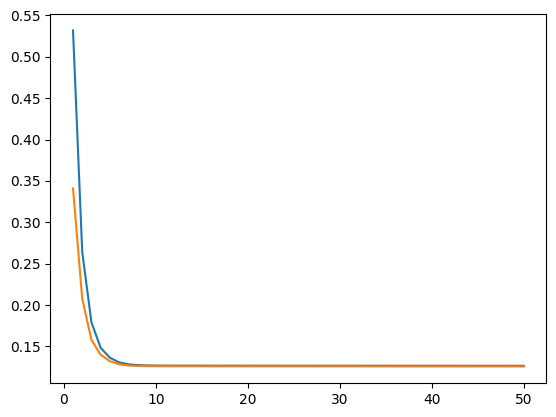

In [99]:
plot.plot(range(1,len(results[0])+1), results[0])
plot.plot(range(1,len(results[1])+1), results[1], label='test')

In [100]:
joblib.dump(net, 'models/convNet1D.joblib')

['models/convNet1D.joblib']